In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/data/example_test_data.csv')

In [ ]:
df

,index,img_path,Latitude,Longitude,Lat_norm,Long_norm,updated_beam_32,feature
0,970,./user_rgb/image970_20_26_25.jpg,33.420308,-111.928911,0.473046,0.821881,16,"[0.33558264, 0.1607849, 0.6215599, 0.11690883,..."
1,2971,./user_rgb/image2971_20_30_44.jpg,33.420415,-111.928919,0.747625,0.742315,25,"[0.0, 0.110622264, 0.04390052, 1.5594708, 0.35..."
2,6746,./user_rgb/image6746_20_38_55.jpg,33.420228,-111.928897,0.265620,0.947559,10,"[0.94763494, 0.8302592, 0.81277645, 0.25638407..."
3,4555,./user_rgb/image4555_20_34_10.jpg,33.420464,-111.928996,0.876639,0.044304,30,"[0.18457206, 0.51359063, 0.15910514, 0.0416843..."
4,1245,./user_rgb/image1245_20_27_01.jpg,33.420426,-111.928995,0.777858,0.056058,28,"[0.20767123, 0.9880108, 0.30163732, 0.07865772..."
...,...,...,...,...,...,...,...,...
94,7725,./user_rgb/image7725_20_41_04.jpg,33.420387,-111.928925,0.675540,0.690778,23,"[0.0, 0.415135, 0.33139706, 0.22600698, 0.0858..."
95,3673,./user_rgb/image3673_20_32_16.jpg,33.420429,-111.928921,0.784364,0.729656,26,"[0.09350825, 0.26110986, 0.2597464, 1.4871106,..."
96,288,./user_rgb/image288_20_24_56.jpg,33.420322,-111.928912,0.507771,0.804702,16,"[0.4775059, 0.11414668, 0.625038, 0.06278287, ..."
97,7306,./user_rgb/image7306_20_40_09.jpg,33.420387,-111.928991,0.676960,0.094033,23,"[0.07371894, 0.468292, 0.078230076, 0.3523835,..."


In [ ]:
import os
import random
import pandas as pd
import torch
import numpy as np
import random
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import ast
import json

In [ ]:
print(row[4:7])

[0.473045544, 0.821880651, 16]


In [ ]:
print(row[7])

[0.33558264, 0.1607849, 0.6215599, 0.11690883, 0.22098076, 0.6058282, 1.2042733, 1.0989418, 0.6232427, 0.34424758, 0.4435368, 0.030033631, 0.77115655, 0.11762282, 0.4999746, 0.13024504, 1.0534794, 0.14418088, 1.4558527, 0.7872759, 0.20408782, 0.79854745, 1.2245611, 0.054738317, 0.40565148, 0.12561795, 0.7918547, 0.7709925, 0.2936372, 0.31489822, 0.9899927, 0.26281533, 0.3281492, 0.15104808, 0.50661683, 0.15480818, 0.28087682, 0.40227807, 0.26851997, 0.13766478, 0.23487352, 0.665695, 0.060380623, 0.67594784, 0.36149955, 0.067061014, 0.2614197, 0.3391865, 0.7402449, 0.9962171, 0.21319541, 0.5723193, 1.3544679, 1.4809552, 1.1504743, 1.4899058, 0.1239577, 0.06716275, 0.8044536, 0.14679092, 0.21938355, 0.07833822, 0.34234884, 0.92306685, 0.07502491, 0.8054439, 0.15728094, 0.12177501, 0.40851453, 0.5348013, 0.5258263, 0.2749095, 0.38580462, 0.30466074, 1.409199, 0.3467692, 0.5375971, 0.44481635, 0.041963056, 0.63993984, 0.3670117, 0.23632844, 1.1427473, 1.1486785, 0.52512217, 0.5500315, 0.24

In [ ]:
feature = row[7]

In [ ]:
############### Create data sample list #################
def create_samples(root, shuffle=False, nat_sort=False):
    f = pd.read_csv(root)
    data_samples = []
    pred_val = []
    for idx, row in f.iterrows():
      #the feature vector of the images -> target
        feature = row.values[7]
        feature = json.loads(feature)
            # the  features to train the model [Lat_norm,Long_norm,updated_beam_32]
        loc_beam = row.values[4:7]
        tmp = [feature, loc_beam]
        tmp_flatten = [item for items in tmp for item in items]
        data_samples.append(tmp_flatten)

    return data_samples #[[feature, loc_beam],[feature, loc_beam]....]
#############################################################

class DataFeed(Dataset):
    '''
    A class retrieving a tuple of (image,label). It can handle the case
    of empty classes (empty folders).
    '''
    def __init__(self,root_dir, nat_sort = False, transform=None, init_shuflle = True):
        self.root = root_dir
        self.samples = create_samples(self.root,shuffle=init_shuflle,nat_sort=nat_sort)
        self.transform = transform
        self.seq_len = 2051



    def __len__(self):
        return len( self.samples )

    def __getitem__(self, idx):
      # sample = [[feature, loc_beam],[feature, loc_beam]....] ;; loc_beam=[Lat_norm,Long_norm,updated_beam_32]
        sample = self.samples[idx]
        #here we create a tensor with null values 
        pos_data = torch.zeros((self.seq_len,))
        for i,s in enumerate(sample):
          #enumerate is useful for obtaining an indexed list:(0, seq[0]), (1, seq[1]), (2, seq[2]), ...
          #When you use enumerate(), the function gives you back two loop variables:

                     #The count of the current iteration
                     #The value of the item at the current iteration
                    # 0 a
                    # 1 b
                    # 2 c
                   #print(values[0]) -> a
          #in our case i=the count & s=the vlaue wich is the sample (the image vectors,gps position and beam index)
            x = s
            #here we store the data into a torch tensor
            pos_data[i] = torch.tensor(x, requires_grad=False)
        return pos_data

In [ ]:
    import os
    import datetime
    import sys
    import torch as t
    import torch
    import torch.cuda as cuda
    import torch.optim as optimizer
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
    import torchvision.transforms as transf
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage import io, transform
    from scipy import io
    from torchsummary import summary
    import ast
    import csv
    import os

In [ ]:
    isExists = os.path.exists('./checkpoint')
    if not isExists:
        os.makedirs('./checkpoint') 
        
    isExists = os.path.exists('./saved_analysis_file')
    if not isExists:
        os.makedirs('./saved_analysis_file') 

Having fewer parameters is only one way of preventing our model from getting overly complex. But it is actually a very limiting strategy. More parameters mean more interactions between various parts of our neural network. And more interactions mean more non-linearities. These non-linearities help us solve complex problems.

However, we don’t want these interactions to get out of hand. Hence, what if we penalize complexity. We will still use a lot of parameters, but we will prevent our model from getting too complex. This is how the idea of weight decay came up.
https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab


In [ ]:
    
    # Hyper-parameters
    batch_size = 128
    val_batch_size = 1
    #the learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function
    lr = 0.001
    decay = 1e-4
    image_grab = False
    num_epochs = 150
    train_size = [1]

**TORCHVISION.TRANSFORMS**
Transforms are common image transformations. They can be chained together using Compose. Additionally, there is the torchvision.transforms.functional module. Functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input. Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width. Batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch. Deterministic or random transformations applied on the batch of Tensor Images identically transform all the images of the batch.

**Compositions of transforms**
CLASS torchvision.transforms.Compose(transforms)

Composes several transforms together. This transform does not support torchscript. Please, see the note below.

Parameters:	transforms (list of Transform objects) – list of transforms to compose.
Example

>>> transforms.Compose([
>>>     transforms.CenterCrop(10),
>>>     transforms.ToTensor(),
>>> ]) 

In [ ]:
    # Data pre-processing:
    proc_pipe = transf.Compose(
        [
         transf.ToTensor()
        ]
    )
    train_dir = '/content/gdrive/MyDrive/data/example_train_data.csv'
    val_dir = '/content/gdrive/MyDrive/data/example_test_data.csv'
  #because our dataset is huge we will have to train the model in batches and we will use pytorch's DataLoader class : we will tell it which dataste to use (in our case DataFeed(train_dir, transform = proc_pipe)), the desired batch size and if we'd like to shuffle it or not
  #our loader will behave like an iterator so we can loop over it and fetch a different mini-batch everytime.

    train_loader = DataLoader(DataFeed(train_dir, transform = proc_pipe),
                              batch_size=batch_size,
                              shuffle=False)
                              
    val_loader = DataLoader(DataFeed(val_dir, transform=proc_pipe),
                            batch_size=val_batch_size,
                            shuffle=False)
                            
    now = datetime.datetime.now()

In [ ]:
    # Hyperparameters for our network
    input_size = 2050
    hidden_sizes = [512 , 512]
    hidden_sizes1 = [512, 512]
    output_size = 64
    

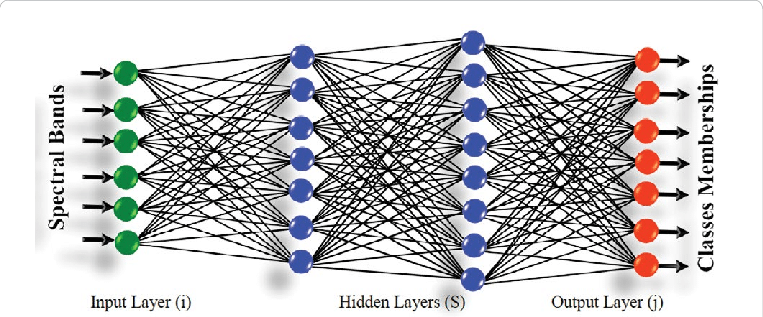

In [ ]:
    # Build a feed-forward network
    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.BatchNorm1d(512),
                          nn.Dropout(0.5),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes1[0]),
                          nn.BatchNorm1d(512),
                          nn.Dropout(0.5),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes1[0], output_size),
                          )    

In [ ]:
train_size = [1]
len(train_size)

1

In [ ]:
#MultiStepLR explained
import torch
model = [Parameter(torch.randn(2, 2, requires_grad=True))]
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1, last_epoch=-1, verbose=False)
for epoch in range(20):
    for input, target in dataset:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()

In [ ]:
    #Network training:
        #By default, torch.device(‘cuda’) refers to GPU index 0. Similarly, tensor.cuda() and model.cuda() move the tensor/model to “cuda: 0” by default if not specified.
    #in our code we did :     import torch.cuda as cuda
    #i think here we will move the tensors and model to cuda (means to GPU)
    # train_size = [1]
    val_acc = []
    with cuda.device(0):
        top_1 = np.zeros( (1,len(train_size)) )
        top_2 = np.zeros( (1,len(train_size)) )
        top_3 = np.zeros( (1,len(train_size)) )
        acc_loss = 0
        itr = []
        for idx, n in enumerate(train_size):
            print('```````````````````````````````````````````````````````')
            print('Training size is {}'.format(n))
            # Build the network:
            #we load the model to GPU
            net = model.cuda()
            #we list the model's layers
            layers = list(net.children())
    
            #  Optimization parameters:
            ##we define the loss function
            criterion = nn.CrossEntropyLoss()
            #the optimizer is adam -> the optimizer takes the parameters we want to update (net.parameters() the model's parameters), takes also the learning rate we want to use and the weight decay -> and then performs the update
            opt = optimizer.Adam(net.parameters(), lr=lr, weight_decay=decay)
            #we will use a Multi-Step Learning Rate (MultiStepLR) scheduler
            #The MultiStepLR is a scheduling technique that decays the learning rate of each parameter group by gamma once the number of epochs reaches one of the milestones.
            #Milestones - the indices (numbers) of epochs after which the learning rate is reduced;
            #Gamma - a multiplicative factor by which the learning rate is decayed. For instance, if the learning rate is 1000 and gamma is 0.5, the new learning rate will be 1000 x 0.5 = 500.
            LR_sch = optimizer.lr_scheduler.MultiStepLR(opt, [6, 20], gamma=0.1, last_epoch=-1)
            
    
            count = 0
            running_loss = []
            running_top1_acc = []
            running_top2_acc = []
            running_top3_acc = []
            
            for epoch in range(num_epochs):
                print('Epoch No. ' + str(epoch + 1))
                skipped_batches = 0
                for tr_count, y in enumerate(train_loader):
                  #tr_count : the count #The count of the current iteration
                  #y :The value of the item at the current iteration, y contains the value of train loader = the trainset
                  #net is our model
                  #here we will train it (after we load it on cuda)
                    net.train()
                  #in pytorch a dataset is represented by a regular python class that inherits from the dataset class, it's like a python list of tuples , earch tuple corresponding to 1 point (data,label)
                    #normalement data is the image feature vector and the gps data
                    data = y[:, :-1].type(torch.Tensor)    
                    #normalement label is the beam_index              
                    label = y[:, -1].long()      
                    #we load the data (or the features) to cuda                
                    x = data.cuda()
                    #we need to 0 out gradients after each update
                    opt.zero_grad()
                    #we load the label (or the target) to cuda 
                    label = label.cuda() #this is the true value of the beam index
                    #here we perform a forward pass and perdict the output 
                    out = net.forward(x) #out is the model's prediction of the beam index
                    #we calculate the loss of forward pass 
                    loss = criterion(out, label)
                    #then we perform a backward : automatic differentiation package / don't need to worry about partial differentiation , chain rule ...
                    loss.backward()
                    #we perform an optimazation
                    opt.step()                    
                    batch_loss = loss.item()
                    acc_loss += batch_loss
                    count += 1
                    if np.mod(count, 10) == 0:
                        print('Training-Batch No.' + str(count))
                        running_loss.append(batch_loss)  # running_loss.append()
                        itr.append(count)
                        print('Loss = ' + str(running_loss[-1]))




















                        
    
                print('Start validation')
                ave_top1_acc = 0
                ave_top2_acc = 0
                ave_top3_acc = 0
                
                ind_ten = t.as_tensor([0, 1, 2], device='cuda:0')
                top1_pred_out = []
                top2_pred_out = []
                top3_pred_out = []
                total_count = 0
                intermediate_out = []
                #afte the training will we evaluate the model on the validation data (val_loader)
                for val_count, y in enumerate(val_loader):
                  #net is our model , and here we use .eval
                    net.eval()
                    #we perform the same work like we did in training but the only changement is here we work on the validation dataset
                    #data are our features
                    data = y[:, :-1].type(torch.Tensor) 
                    #we load them to cuda
                    x = data.cuda() 
                    #labels are our true beam indexes                    
                    labels = y[:, -1].long()  
                    #initialize optemazation
                    opt.zero_grad()
                    #load labels to cuda
                    labels = labels.cuda()
                    total_count += labels.size(0)
                    #forwad pass where the model prediction the beams for the data used as input
                    out = net.forward(x)
                    #hna mafhemtouch chyaaml
                    
                    _, top_1_pred = t.max(out, dim=1)
                    top1_pred_out.append(top_1_pred.cpu().numpy())
                    
                    sorted_out = t.argsort(out, dim=1, descending=True)
                    
                    top_2_pred = t.index_select(sorted_out, dim=1, index=ind_ten[0:2])
                    top2_pred_out.append(top_2_pred.cpu().numpy())
                    
                    top_3_pred_0 = t.index_select(sorted_out, dim=1, index=ind_ten[0])
                    top_3_pred_1 = t.index_select(sorted_out, dim=1, index=ind_ten[1])
                    top_3_pred_2 = t.index_select(sorted_out, dim=1, index=ind_ten[2])
                    top_3_pred = t.index_select(sorted_out, dim=1, index=ind_ten)
                    
                    tmp = [top_3_pred_0.item(), top_3_pred_1.item(), top_3_pred_2.item() ]
                    top3_pred_out.append(tmp)             
                    
                    reshaped_labels = labels.reshape((labels.shape[0], 1))
                    tiled_2_labels = reshaped_labels.repeat(1, 2)
                    tiled_3_labels = reshaped_labels.repeat(1, 3)
                    batch_top1_acc = t.sum(top_1_pred == labels, dtype=t.float32)
                    batch_top2_acc = t.sum(top_2_pred == tiled_2_labels, dtype=t.float32)
                    batch_top3_acc = t.sum(top_3_pred == tiled_3_labels, dtype=t.float32)
                    

                    ave_top1_acc += batch_top1_acc.item()
                    ave_top2_acc += batch_top2_acc.item()
                    ave_top3_acc += batch_top3_acc.item()
                    
                print("total test examples are", total_count)
                running_top1_acc.append(ave_top1_acc / total_count)  # (batch_size * (count_2 + 1)) )
                running_top2_acc.append(ave_top2_acc / total_count)
                running_top3_acc.append(ave_top3_acc / total_count)  # (batch_size * (count_2 + 1)))
                print('Training_size {}--No. of skipped batchess {}'.format(n,skipped_batches))
                print('Average Top-1 accuracy {}'.format( running_top1_acc[-1]))
                print('Average Top-2 accuracy {}'.format( running_top2_acc[-1]))
                print('Average Top-3 accuracy {}'.format( running_top3_acc[-1]))
                print("Saving the predicted value in a csv file")
                tmp = [running_top1_acc[-1], running_top2_acc[-1], running_top3_acc[-1]]
                val_acc.append(tmp)
                
                with open("./intermediate_output.csv", "w", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerows(zip(intermediate_out))
                with open("./saved_analysis_file/top1_pred_beam_val_after_%sth_epoch.csv"%(epoch+1), "w", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerows(zip(top1_pred_out))
                with open("./saved_analysis_file/top2_pred_beam_val_afte_%sth_epoch.csv"%(epoch+1), "w", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerows(zip(top2_pred_out))  
                with open("./saved_analysis_file/top3_pred_beam_val_after_%sth_epoch.csv"%(epoch+1), "w", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerows(zip(top3_pred_out))               
    
                LR_sch.step()
            top_1[0,idx] = running_top1_acc[-1]
            top_2[0,idx] = running_top2_acc[-1]
            top_3[0,idx] = running_top3_acc[-1]
    
    net_name = 'checkpoint/image_pos_beam_pred_ckpt'
    t.save(net.state_dict(), net_name)

```````````````````````````````````````````````````````
Training size is 1
Epoch No. 1
Start validation
total test examples are 99
Training_size 1--No. of skipped batchess 0
Average Top-1 accuracy 0.37373737373737376
Average Top-2 accuracy 0.5454545454545454
Average Top-3 accuracy 0.6161616161616161
Saving the predicted value in a csv file
Epoch No. 2
Start validation
total test examples are 99
Training_size 1--No. of skipped batchess 0
Average Top-1 accuracy 0.4444444444444444
Average Top-2 accuracy 0.6565656565656566
Average Top-3 accuracy 0.7474747474747475
Saving the predicted value in a csv file
Epoch No. 3
Start validation
total test examples are 99
Training_size 1--No. of skipped batchess 0
Average Top-1 accuracy 0.5151515151515151
Average Top-2 accuracy 0.6767676767676768
Average Top-3 accuracy 0.7777777777777778
Saving the predicted value in a csv file
Epoch No. 4
Start validation
total test examples are 99
Training_size 1--No. of skipped batchess 0
Average Top-1 accuracy 0.52

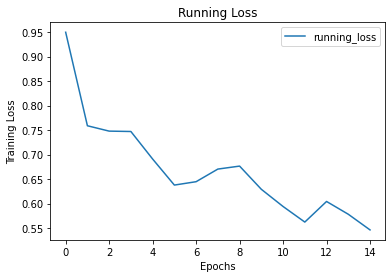

In [ ]:
import matplotlib.pyplot as plt
plt.plot(running_loss, label='running_loss')
plt.title("Running Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()

plt.show()


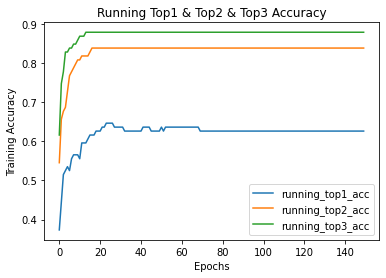

In [ ]:
plt.plot(running_top1_acc,label='running_top1_acc')
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.plot(running_top2_acc,label='running_top2_acc')
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.plot(running_top3_acc,label='running_top3_acc')
plt.title("Running Top1 & Top2 & Top3 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()

Text(0, 0.5, 'Training Accuracy')

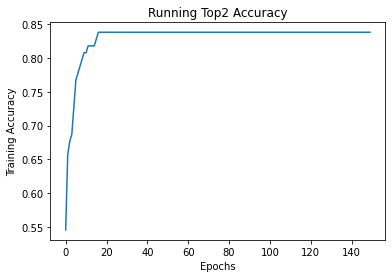

In [ ]:
plt.plot(running_top2_acc)
plt.title("Running Top2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Training Accuracy')

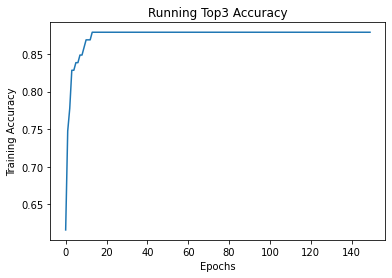

In [ ]:
plt.plot(running_top3_acc)
plt.title("Running Top3 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")